In [1]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2

import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

In [ ]:
# pip install einops

In [2]:
import einops

In [3]:
import os

In [4]:
path = os.getcwd()

In [5]:
path

'd:\\a27_YEARS_OLD\\deep_learning\\CV'

In [6]:
def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped. 

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files


In [7]:
def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

In [8]:
def get_files_per_class(files):
  """
    Retrieve the files that belong to each class. 

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class


# {'class_name':[
#   'file_directory11',
#   'file_directory12',
#   'file_directory13',
#   ]
# }

In [9]:
def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

In [10]:
def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

In [11]:
def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

# {'class_name':[
#   'file_directory11',
#   'file_directory12',
#   'file_directory13',
#   ],
#   'class_name2':[
#     'file_directory21',
  #   'file_directory22',
  #   'file_directory23',
  #   ],
  #   ...
  # }
  # num_classes =10 upto  10 classes



  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs


In [ ]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

In [ ]:
download_dir = pathlib.Path(path + '/UCF101_subset/')

In [ ]:


subset_paths = download_ufc_101_subset(URL, 
                        num_classes = 10, 
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

train :


  1%|          | 2/300 [00:06<16:24,  3.30s/it]


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'd:\\a27_YEARS_OLD\\deep_learning\\CV\\UCF101_subset\\train\\ApplyEyeMakeup\\UCF101\\v_ApplyEyeMakeup_g07_c06.avi' -> 'd:\\a27_YEARS_OLD\\deep_learning\\CV\\UCF101_subset\\train\\ApplyEyeMakeup\\v_ApplyEyeMakeup_g07_c06.avi'

In [13]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [14]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result


In [24]:
import pathlib

In [25]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """

    # convert string to Path object
    self.path = pathlib.Path(path)
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [18]:
download_dir = pathlib.Path(path + '/UCF101_subset/')

In [26]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(os.path.join(download_dir , 'train'), n_frames, training=True),
                                          output_signature = output_signature)  #subset_paths['train']


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(os.path.join(download_dir,'val'), n_frames),
                                        output_signature = output_signature) #subset_paths['val']
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(os.path.join(download_dir , 'test'), n_frames),
                                         output_signature = output_signature) #subset_paths['test']

test_ds = test_ds.batch(batch_size)

In [27]:
output_signature

(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int16, name=None))

In [28]:

train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int16, name=None))>

In [31]:
next(iter(test_ds))

(<tf.Tensor: shape=(8, 10, 224, 224, 3), dtype=float32, numpy=
 array([[[[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],


Create the model
The following 3D convolutional neural network model is based off the paper A Closer Look at Spatiotemporal Convolutions for Action Recognition by D. Tran et al. (2017). The paper compares several versions of 3D ResNets. Instead of operating on a single image with dimensions (height, width), like standard ResNets, these operate on video volume (time, height, width). The most obvious approach to this problem would be replace each 2D convolution (layers.Conv2D) with a 3D convolution (layers.Conv3D).

This tutorial uses a (2 + 1)D convolution with residual connections. The (2 + 1)D convolution allows for the decomposition of the spatial and temporal dimensions, therefore creating two separate steps. An advantage of this approach is that factorizing the convolutions into spatial and temporal dimensions saves parameters.

For each output location a 3D convolution combines all the vectors from a 3D patch of the volume to create one vector in the output volume.

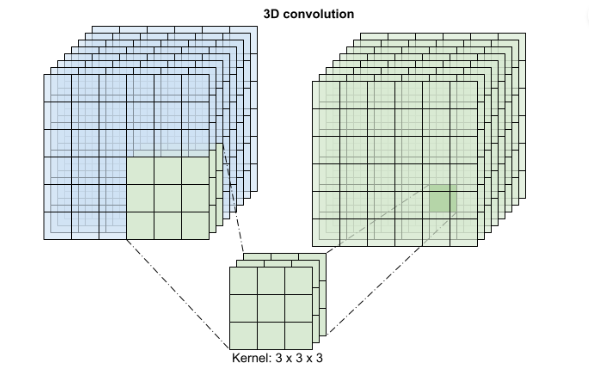

This operation is takes time * height * width * channels inputs and produces channels outputs (assuming the number of input and output channels are the same. So a 3D convolution layer with a kernel size of (3 x 3 x 3) would need a weight-matrix with 27 * channels ** 2 entries. The reference paper found that a more effective & efficient approach was to factorize the convolution. Instead of a single 3D convolution to process the time and space dimensions, they proposed a "(2+1)D" convolution which processes the space and time dimensions separately. The figure below shows the factored spatial and temporal convolutions of a (2 + 1)D convolution.



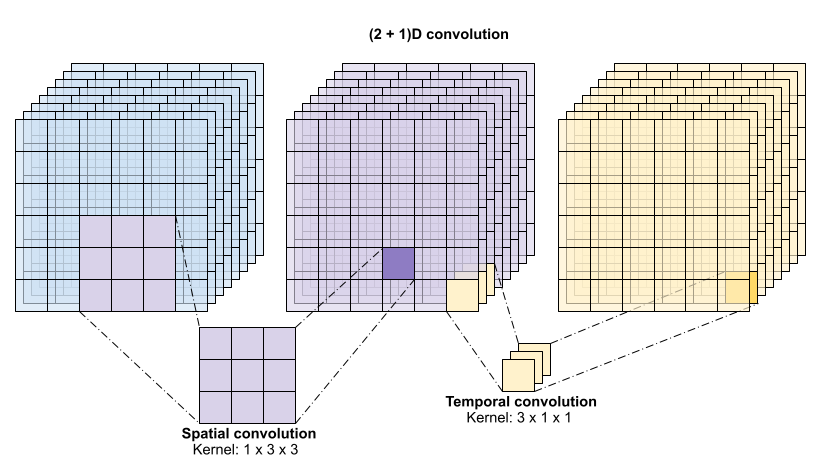

In [32]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [33]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

A ResNet model is made from a sequence of residual blocks. A residual block has two branches. The main branch performs the calculation, but is difficult for gradients to flow through. The residual branch bypasses the main calculation and mostly just adds the input to the output of the main branch. Gradients flow easily through this branch. Therefore, an easy path from the loss function to any of the residual block's main branch will be present. This avoids the vanishing gradient problem.

Create the main branch of the residual block with the following class. In contrast to the standard ResNet structure this uses the custom Conv2Plus1D layer instead of layers.Conv2D.

In [34]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

To add the residual branch to the main branch it needs to have the same size. The Project layer below deals with cases where the number of channels is changed on the branch. In particular, a sequence of densely-connected layer followed by normalization is added.

In [35]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

se add_residual_block to introduce a skip connection between the layers of the model.

In [36]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

Resizing the video is necessary to perform downsampling of the data. In particular, downsampling the video frames allow for the model to examine specific parts of frames to detect patterns that may be specific to a certain action. Through downsampling, non-essential information can be discarded. Moreoever, resizing the video will allow for dimensionality reduction and therefore faster processing through the mode

In [38]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
# einops.rearrange(video, 'b t h w c -> (b t) h w c'):
# Merges batch (b) and time (t) dimensions into a single dimension (b t).
# Resulting shape: (b*t, h, w, c).
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
#     einops.rearrange(images, '(b t) h w c -> b t h w c', t=old_shape['t']):
# Splits the merged (b t) dimension back into separate b and t dimensions.
# t=old_shape['t'] specifies the original number of frames (t) for proper splitting.
# Resulting shape: (b, t, h, w, c).
    return videos

In [39]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)

input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [40]:
frames, label = next(iter(train_ds))
model.build(frames)

In [41]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [44]:
frames[0]

<tf.Tensor: shape=(10, 224, 224, 3), dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


 

Train the model
For this tutorial, choose the tf.keras.optimizers.Adam optimizer and the tf.keras.losses.SparseCategoricalCrossentropy loss function. Use the metrics argument to the view the accuracy of the model performance at every step.

In [45]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [47]:
history = model.fit(x = train_ds,
                    epochs = 3,
                    steps_per_epoch =10, 
                    validation_data = val_ds)

Epoch 1/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 65s 7s/step - accuracy: 0.1257 - loss: 2.5220 - val_accuracy: 0.1600 - val_loss: 2.2767
Epoch 2/3


d:\a27_YEARS_OLD\deep_learning\venv\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


10/10 ━━━━━━━━━━━━━━━━━━━━ 60s 6s/step - accuracy: 0.1809 - loss: 2.2749 - val_accuracy: 0.1700 - val_loss: 2.2835
Epoch 3/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 6s/step - accuracy: 0.2420 - loss: 2.1986 - val_accuracy: 0.2100 - val_loss: 2.3648


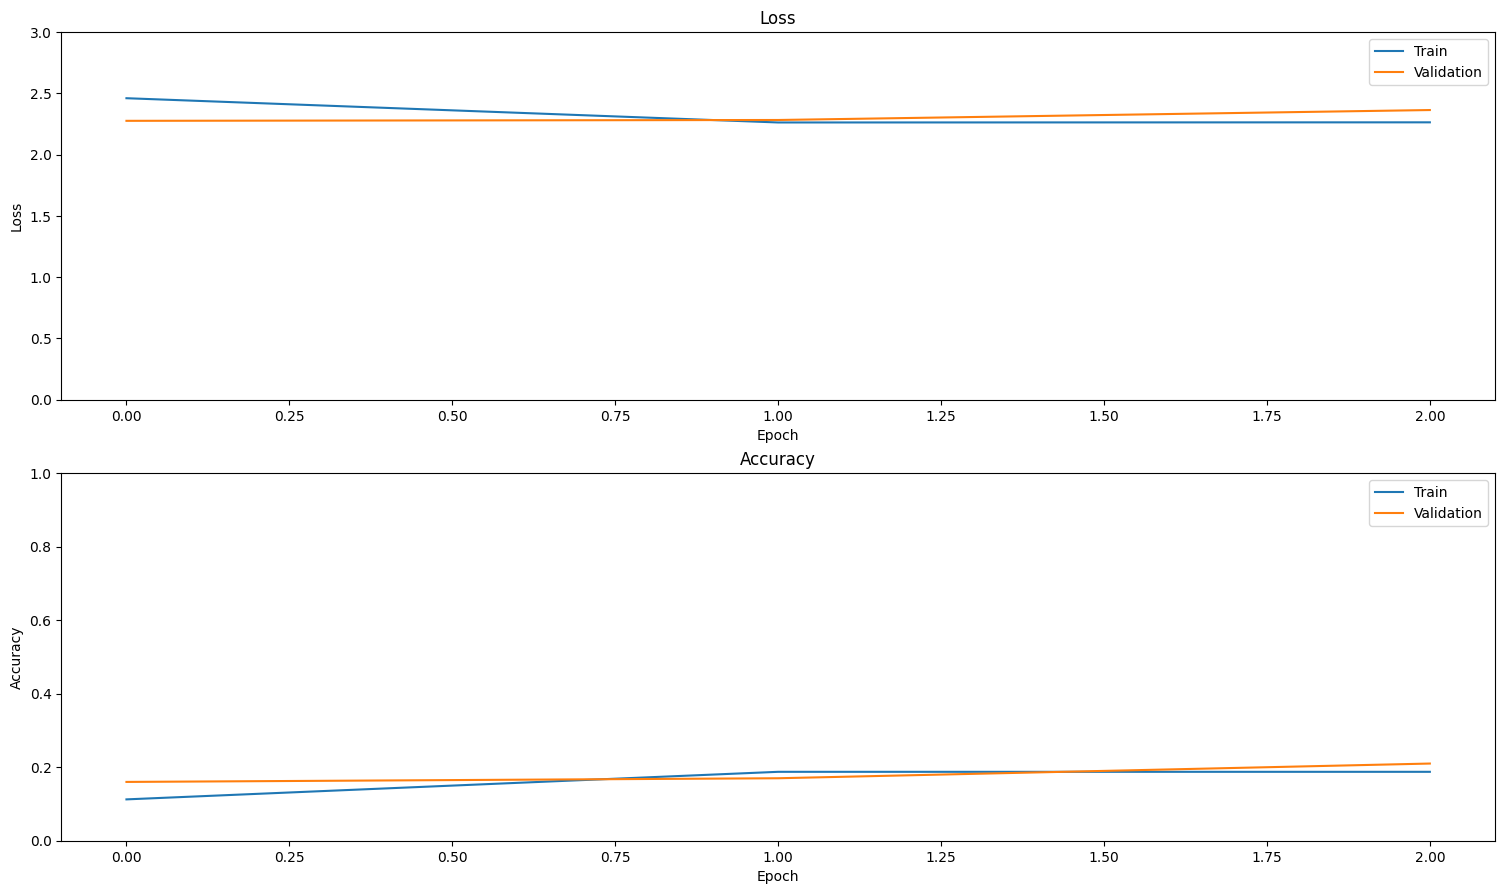

In [48]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

In [49]:
model.evaluate(test_ds, return_dict=True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1135 - loss: 2.3396


{'accuracy': 0.1599999964237213, 'loss': 2.4281084537506104}

To visualize model performance further, use a confusion matrix. The confusion matrix allows you to assess the performance of the classification model beyond accuracy. In order to build the confusion matrix for this multi-class classification problem, get the actual values in the test set and the predicted values.

In [50]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [68]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  print(cm)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [54]:
fg = FrameGenerator(os.path.join(download_dir , 'train'), n_frames, training=True)


In [55]:
fg

In [56]:
labels = list(fg.class_ids_for_name.keys())

In [57]:
labels

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'Basketball',
 'BasketballDunk',
 'BenchPress']

In [60]:
# actual, predicted = get_actual_predicted_labels(train_ds)
# plot_confusion_matrix(actual, predicted, labels, 'training')

In [53]:
actual, predicted = get_actual_predicted_labels(test_ds)


13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step


tf.Tensor(
[[0 2 0 0 0 3 0 5 0 0]
 [0 1 0 0 0 1 0 8 0 0]
 [0 1 3 0 0 3 0 2 1 0]
 [0 0 2 0 0 3 0 5 0 0]
 [0 0 0 0 0 3 0 4 3 0]
 [0 3 1 0 0 4 0 1 1 0]
 [0 1 0 0 0 1 0 8 0 0]
 [0 2 1 0 0 5 0 2 0 0]
 [0 0 0 0 0 0 0 4 6 0]
 [0 1 0 0 0 6 0 1 2 0]], shape=(10, 10), dtype=int32)


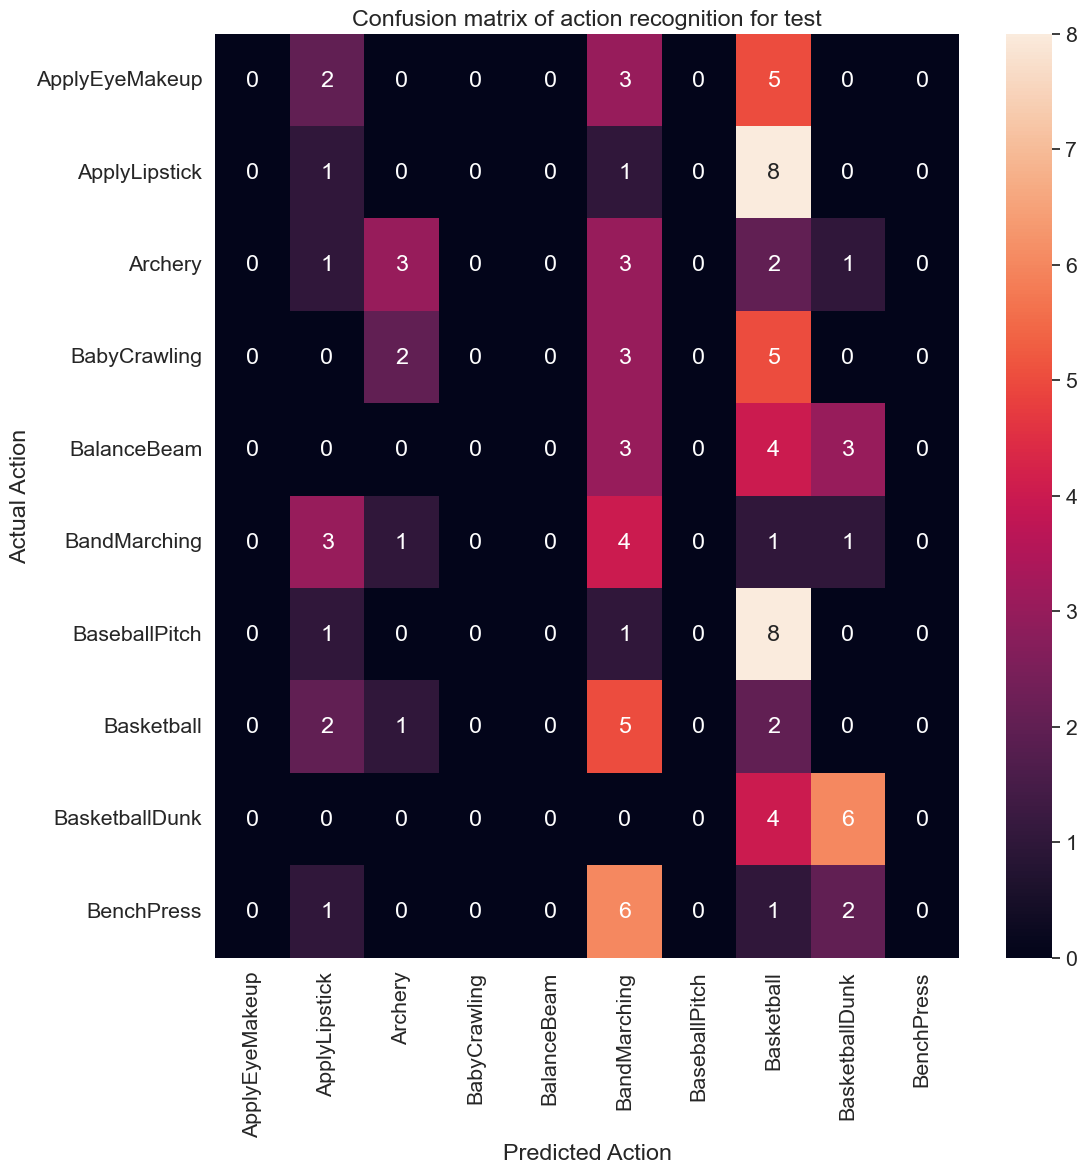

In [69]:
plot_confusion_matrix(actual, predicted, labels, 'test')

In [ ]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  print(cm)
  tp = np.diag(cm) # Diagonal represents true positives
  print(tp)
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    print(col)
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    print(fp)

    row = cm[i, :]
    print(row)
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    print(fn)
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 

    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

  return precision, recall

In [ ]:
# 	Predicted Class 0	Predicted Class 1
# Actual Class 0	3 (TP)	2 (FP)
# Actual Class 1	1 (FN)	4 (TP)
# For class 0:
# Column sum (np.sum(col)) = 3 (TP) + 1 (FN) = 4
# tp[i] = 3 (TP)
# fp = 4 (column sum) - 3 (TP) = 1 (FP)
# So, fp correctly calculates the false positives for class 0.

In [67]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

tf.Tensor(
[[0 2 0 0 0 3 0 5 0 0]
 [0 1 0 0 0 1 0 8 0 0]
 [0 1 3 0 0 3 0 2 1 0]
 [0 0 2 0 0 3 0 5 0 0]
 [0 0 0 0 0 3 0 4 3 0]
 [0 3 1 0 0 4 0 1 1 0]
 [0 1 0 0 0 1 0 8 0 0]
 [0 2 1 0 0 5 0 2 0 0]
 [0 0 0 0 0 0 0 4 6 0]
 [0 1 0 0 0 6 0 1 2 0]], shape=(10, 10), dtype=int32)
[0 1 3 0 0 4 0 2 6 0]
tf.Tensor([0 0 0 0 0 0 0 0 0 0], shape=(10,), dtype=int32)
0
tf.Tensor([0 2 0 0 0 3 0 5 0 0], shape=(10,), dtype=int32)
10
tf.Tensor([2 1 1 0 0 3 1 2 0 1], shape=(10,), dtype=int32)
10
tf.Tensor([0 1 0 0 0 1 0 8 0 0], shape=(10,), dtype=int32)
9
tf.Tensor([0 0 3 2 0 1 0 1 0 0], shape=(10,), dtype=int32)
4
tf.Tensor([0 1 3 0 0 3 0 2 1 0], shape=(10,), dtype=int32)
7
tf.Tensor([0 0 0 0 0 0 0 0 0 0], shape=(10,), dtype=int32)
0
tf.Tensor([0 0 2 0 0 3 0 5 0 0], shape=(10,), dtype=int32)
10
tf.Tensor([0 0 0 0 0 0 0 0 0 0], shape=(10,), dtype=int32)
0
tf.Tensor([0 0 0 0 0 3 0 4 3 0], shape=(10,), dtype=int32)
10
tf.Tensor([3 1 3 3 3 4 1 5 0 6], shape=(10,), dtype=int32)
25
tf.Tensor([0 3 1 0 0 4 0 1 1 0

C:\Users\lenovo\AppData\Local\Temp\ipykernel_17708\1232924895.py:30: RuntimeWarning: invalid value encountered in scalar divide
  precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision


In [64]:
precision

{'ApplyEyeMakeup': np.float64(nan),
 'ApplyLipstick': np.float64(0.09090909090909091),
 'Archery': np.float64(0.42857142857142855),
 'BabyCrawling': np.float64(nan),
 'BalanceBeam': np.float64(nan),
 'BandMarching': np.float64(0.13793103448275862),
 'BaseballPitch': np.float64(nan),
 'Basketball': np.float64(0.05),
 'BasketballDunk': np.float64(0.46153846153846156),
 'BenchPress': np.float64(nan)}

In [65]:
recall

{'ApplyEyeMakeup': np.float64(0.0),
 'ApplyLipstick': np.float64(0.1),
 'Archery': np.float64(0.3),
 'BabyCrawling': np.float64(0.0),
 'BalanceBeam': np.float64(0.0),
 'BandMarching': np.float64(0.4),
 'BaseballPitch': np.float64(0.0),
 'Basketball': np.float64(0.2),
 'BasketballDunk': np.float64(0.6),
 'BenchPress': np.float64(0.0)}